In [17]:
%pip install -U pip
%pip install "tensorflow==2.19." "tensorboard==2.19."
%pip install "keras>=3.3,<4" "keras-hub>=0.16,<1" "keras-nlp>=0.13,<1"

Note: you may need to restart the kernel to use updated packages.
ERROR: Invalid requirement: 'tensorflow==2.19.': Expected end or semicolon (after version specifier)
    tensorflow==2.19.
              ~~~~~~^
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
%pip install tensorflow-datasets scikit-learn pandas numpy matplotlib pillow gensim

Note: you may need to restart the kernel to use updated packages.


Bruno Arezo, Ivan Gonzalez, Camila Pazos

In [19]:
from IPython.display import clear_output

!pip uninstall  -y numpy
!pip -q install numpy==1.26.4
!pip install streamlit

clear_output()

In [20]:


import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import keras_hub
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16, efficientnet, resnet
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
#from gensim.models import KeyedVectors
from IPython.display import clear_output
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_covtype
from sklearn.metrics import roc_auc_score

clear_output()

print("Se han importado todas las librerías correctamente")

Se han importado todas las librerías correctamente


In [21]:
import tensorflow as tf, tensorflow_datasets as tfds, sklearn, matplotlib, pandas as pd, numpy as np
print("TF:", tf.__version__)            # 2.19.x
import tensorboard as tb; print("TB:", tb.__version__)   # 2.19.x

TF: 2.19.1
TB: 2.19.0


In [22]:
#funciones complementarias
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def plot_curvas(history):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plot_graphs(history, 'accuracy')
  plt.ylim(None, 1)
  plt.subplot(1, 2, 2)
  plot_graphs(history, 'loss')
  plt.ylim(0, None)

def cosine_similarity(vec_a, vec_b):
  """Compute cosine similarity between vec_a and vec_b"""
  return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

# dibujamos ciertos ejemplos de entrenamiento
def plot_imagenes(train_images,train_labels):
  plt.figure(figsize=(10, 4))
  for i in range(10):
      plt.subplot(2, 5, i + 1)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(train_images[i], cmap=plt.cm.gray)
      plt.xlabel(train_labels[i])
  plt.show()

def plot_predicciones(model,test_images):
  plt.figure(figsize=(10, 4))
  for i in range(10):
      plt.subplot(2, 5, i + 1)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(test_images[i], cmap=plt.cm.gray)
      pred = np.argmax(model.predict(np.expand_dims(test_images[i], axis=0), verbose=False))
      plt.xlabel(f"Pred: {pred}")
  plt.show()

In [23]:
import kagglehub

path = kagglehub.dataset_download("yudhaislamisulistya/plants-type-datasets")

print("Path to dataset files:", path)

Path to dataset files: /Users/brunoarezo/.cache/kagglehub/datasets/yudhaislamisulistya/plants-type-datasets/versions/16


In [24]:
# Cargar dataset de plantas
import os
from PIL import Image

dataset_path = "/Users/brunoarezo/.cache/kagglehub/datasets/yudhaislamisulistya/plants-type-datasets/versions/16"

# Buscar imágenes recursivamente
def find_images(root_path):
    image_paths = []
    labels = []
    class_names = []
    
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                parent_folder = os.path.basename(root)
                if parent_folder not in class_names:
                    class_names.append(parent_folder)
                
                image_paths.append(os.path.join(root, file))
                labels.append(class_names.index(parent_folder))
    
    return image_paths, labels, class_names

image_paths, labels, class_names = find_images(dataset_path)
print(f"\nEncontradas {len(image_paths)} imágenes en {len(class_names)} clases")


Encontradas 30000 imágenes en 30 clases


## Procesamiento de los datos

In [25]:
X = []
y = []

for i, img_path in enumerate(image_paths):
    try:
        img = Image.open(img_path).convert("RGB").resize((128, 128))
        X.append(np.array(img))
        y.append(labels[i])
    except Exception as e:
        print(f"Error cargando imagen {img_path}: {e}")

X = np.array(X)
y = np.array(y)

print(f"Dataset cargado:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Dataset cargado:
X shape: (30000, 128, 128, 3)
y shape: (30000,)


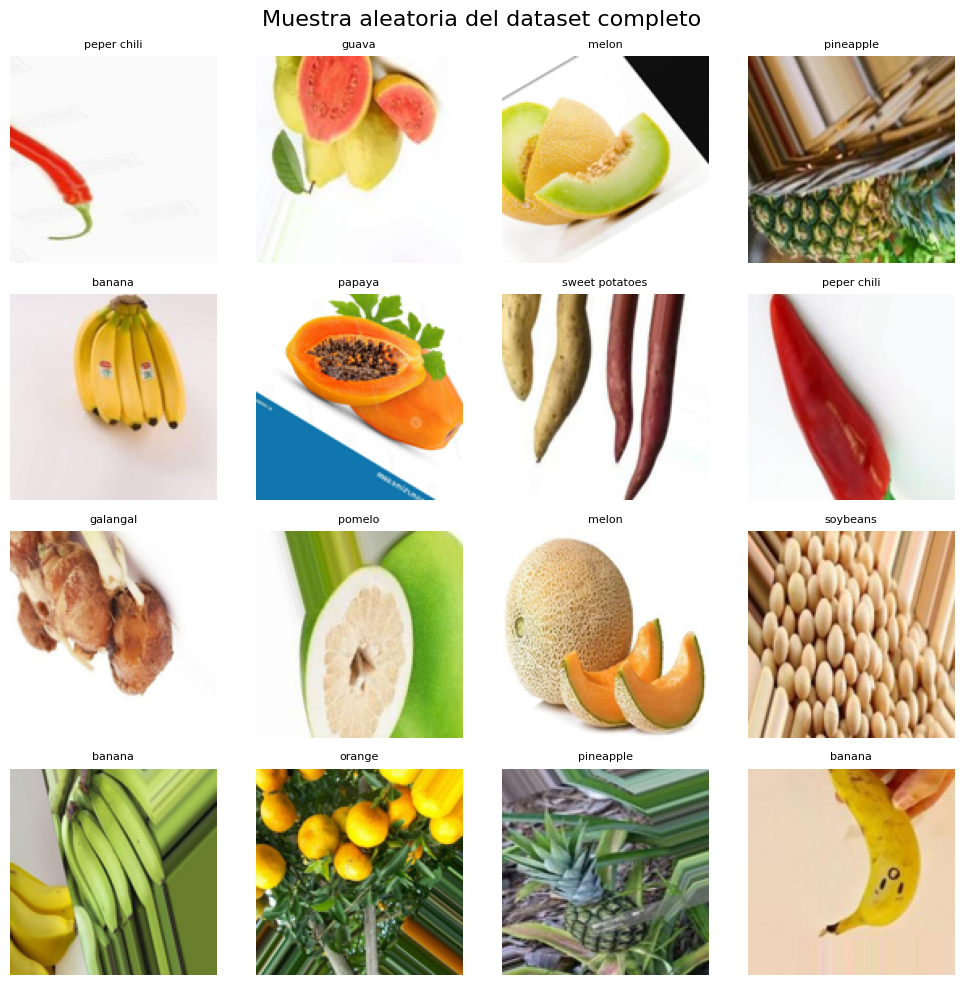

Mostrando 16 imágenes de 30000 totales


In [26]:
# Muestra aleatoria del dataset 
import random

# Selecciona 16 imágenes aleatorias
num_samples = 16
random_indices = random.sample(range(len(X)), min(num_samples, len(X)))

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Muestra aleatoria del dataset completo', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(random_indices):
        idx = random_indices[i]
        ax.imshow(X[idx])
        ax.set_title(f'{class_names[y[idx]]}', fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Mostrando {len(random_indices)} imágenes de {len(X)} totales")

In [27]:
#Normalizamos entre 0-1
X = X.astype('float32') / 255.0
X.shape     

(30000, 128, 128, 3)

In [28]:
# Dividimos el conjunto en 80% train y 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear VALIDATION desde TRAIN (20% de train → val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)
# Transformamos las etiquetas a one-hot encoding
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_val_categorical = to_categorical(y_val)


print('Dimensión X_train: {}'.format(X_train.shape))
print('Dimensión X_test: {}'.format(X_test.shape))

Dimensión X_train: (19200, 128, 128, 3)
Dimensión X_test: (6000, 128, 128, 3)


## Modelo pre-entrenado: VGG16

## Fine tunning

In [29]:
# Reiniciar el backend para que las ejecuciones anteriores no interfieran
K.clear_session()

In [30]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in vgg16_base.layers[:12]:  
    layer.trainable = False

# Agregamos mas neuronas después de nuestro modelo pre-entrenado, para hacer un ajuste mas fino
model_2 = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),  
    layers.Dropout(0.7),                   # Aumentamos el Dropout para evitar el sobreajuste
    layers.Dense(30, activation='softmax') # Capa final con 30 clases
])

In [31]:
# compilamos el modelo y definimos una parada temprana para mitigar el sobreajuste en funcion de la perdida
model_2.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [32]:
# Entrenamos nuestro modelo
history = model_2.fit(X_train, y_train_categorical, batch_size=64,
                      epochs=30,
                      validation_data=(X_val, y_val_categorical),
                      callbacks=[early_stopping])

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1535s 5s/step - accuracy: 0.1395 - loss: 3.0409 - val_accuracy: 0.5542 - val_loss: 1.8100
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1545s 5s/step - accuracy: 0.4524 - loss: 1.9330 - val_accuracy: 0.7421 - val_loss: 1.0291
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1548s 5s/step - accuracy: 0.6260 - loss: 1.3117 - val_accuracy: 0.7817 - val_loss: 0.8020
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1614s 5s/step - accuracy: 0.7322 - loss: 0.9512 - val_accuracy: 0.8429 - val_loss: 0.5675
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1666s 6s/step - accuracy: 0.7921 - loss: 0.7240 - val_accuracy: 0.8654 - val_loss: 0.5579
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1674s 6s/step - accuracy: 0.8311 - loss: 0.5902 - val_accuracy: 0.9154 - val_loss: 0.3082
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1672s 6s/step - accuracy: 0.8607 - loss: 0.4949 - val_accuracy: 0.9125 - val_loss: 0.3059
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1679s 6s/step - accuracy: 0.8821 - loss: 0.3929 - 

In [33]:
# Evaluamos el accuracy del modelo en los datos de prueba
test_loss, test_acc = model_2.evaluate(X_test, y_test_categorical)
print(f"Precisión después del fine-tuning avanzado: {test_acc}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.9497 - loss: 0.2452
Precisión después del fine-tuning avanzado: 0.9496666789054871


In [34]:
def plot_training_history(history):
    # 1) PÉRDIDA
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 2) PRECISIÓN
    plt.figure()
    # Algunos objetos history usan 'accuracy', otros 'acc'
    acc_key     = 'accuracy'      if 'accuracy'      in history.history else 'acc'
    val_acc_key = 'val_accuracy'  if 'val_accuracy'  in history.history else 'val_acc'
    plt.plot(history.history[acc_key], label='Train Accuracy')
    if val_acc_key in history.history:
        plt.plot(history.history[val_acc_key], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

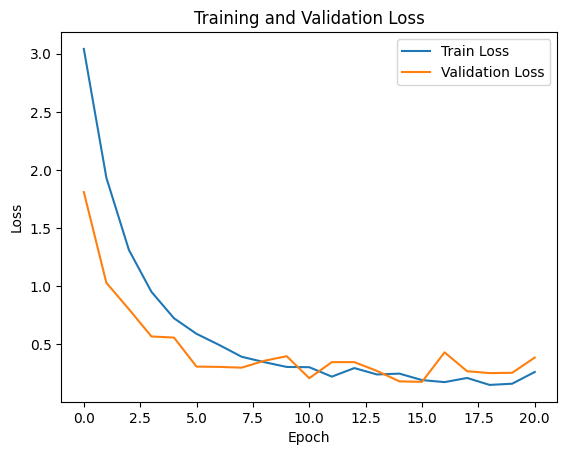

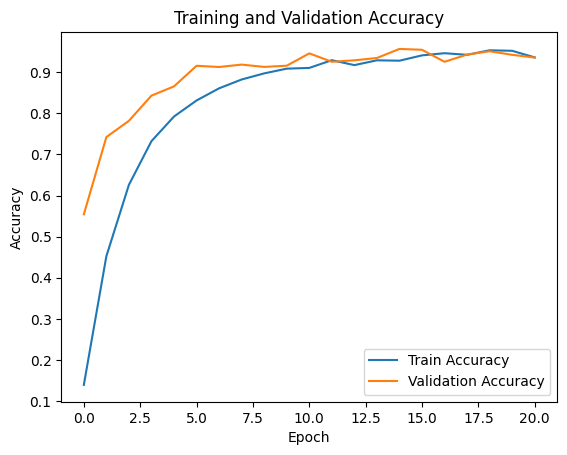

In [35]:
plot_training_history(history)

In [36]:
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [37]:
# predicciones en el conjunto de prueba
y_pred = model_2.predict(X_test)

# Convertir las predicciones en etiquetas (la clase con mayor probabilidad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test  # Las etiquetas reales del conjunto de prueba

188/188 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step


In [38]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_matriz_confusion(cm):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(30), yticklabels=range(30))
    plt.xlabel('Etiqueta predicha')
    plt.ylabel('Etiqueta real')
    plt.title('Matriz de Confusión')
    plt.show()

In [39]:
#reporte de clasificación
print("Reporte de Clasificación:\n")
print(classification_report(y_true, y_pred_classes))

Reporte de Clasificación:

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       206
           1       0.91      0.98      0.94       200
           2       0.98      0.98      0.98       215
           3       0.97      0.95      0.96       192
           4       0.89      0.99      0.94       194
           5       0.94      0.97      0.96       189
           6       0.96      0.98      0.97       196
           7       0.98      0.90      0.94       205
           8       0.97      0.98      0.97       203
           9       0.67      0.96      0.79       206
          10       1.00      0.98      0.99       208
          11       0.97      0.98      0.98       216
          12       0.98      0.91      0.95       215
          13       0.99      0.95      0.97       184
          14       0.91      0.93      0.92       219
          15       0.94      0.97      0.96       193
          16       0.98      0.93      0.96       193


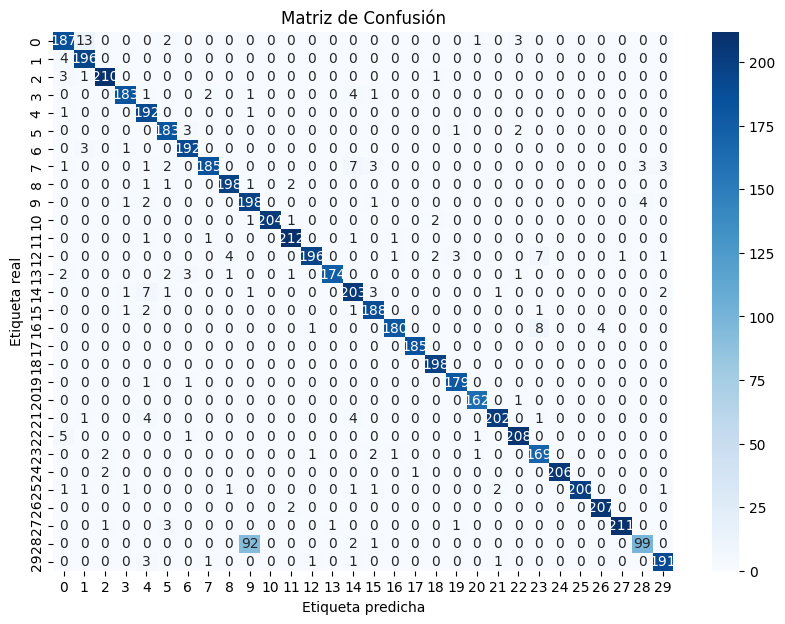

In [40]:
#matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

plot_matriz_confusion(cm)

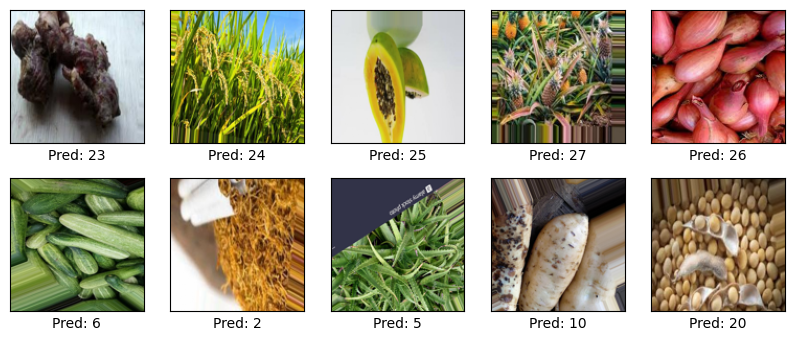

In [41]:
# Dibujamos ciertas imágenes con sus predicciones
plot_predicciones(model_2,X_test)

In [42]:
# Guardar el modelo entrenado
model_2.save('modelo_plantas.keras')
print("Modelo guardado como 'modelo_plantas.keras'")

# Guardar también los nombres de las clases
import pickle
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)
print("Nombres de clases guardados como 'class_names.pkl'")

Modelo guardado como 'modelo_plantas.keras'
Nombres de clases guardados como 'class_names.pkl'
